In [155]:
import numpy as np
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable
import pandas as pd
import emcee
import corner
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

from cluster import c, Cluster, temp_from_vdisp

In [7]:
# consts
n=0 # only collisions for now
norm = 1/4 # normalizing factor for accretion rate
mu = 1  # mean molecular weight of gas, 1 for proton gas (hydrogen)

In [8]:
# testing parameters
nrows = 100

In [9]:
# load data
# load in a dataset here
galwcls=pd.read_csv('data/galwcls.dat', sep='|', header=None, nrows=nrows)
cls_data = {'sig500': galwcls[:][8],
            'M500': galwcls[:][11],
            'r200': galwcls[:][13],
            'sig200':galwcls[:][15],
            'err_neg':galwcls[:][16],
            'err_pos':galwcls[:][17],
            'M200':galwcls[:][18]}
units = {'sig500': u.km/u.s,
            'M500': u.Msun,
            'r200': u.Mpc,
            'sig200': u.km/u.s,
            'err_neg':u.km/u.s,
            'err_pos':u.km/u.s,
            'M200': u.Msun, }
cls_table = QTable(cls_data, units=units)
# add option to select size of dataset


In [91]:
def T_b_small(p0, cluster): # small mx (Tx=0) approximation
    sigma0 = p0[0]*u.cm**2
    m_chi=p0[1]*u.GeV
    
    V=cluster.volume.to(u.cm**3)
    x = (3*const.c*c(n)*V*cluster.rho_dm*cluster.rho_b*sigma0/(cluster.m_b+m_chi)**2).to(1/u.s)
    leading_factors = (norm * 4*np.pi *const.c ** -3).to(u.s**3/u.cm**3)
    gm2 = ((const.G * cluster.bh_mass()) ** 2).to(u.cm**6/u.s**4)
    frac = ((mu * cluster.m_b) ** (5 / 2) / cluster.adiabatic_idx ** (3 / 2)).to(u.GeV**(5/2))
    nb = (2 * cluster.n_e).to(u.cm ** (-3)) # baryon number density
    D = (cluster.epsilon*leading_factors*gm2*frac*(1/nb**(2/3))**(-3/2)) # removed k_B from original function because we are working in GeV here
    return (((D*np.sqrt(cluster.m_b))/x)**(1/3)).to(u.GeV, equivalencies=u.temperature_energy())
    

In [ ]:
# TODO: use fsolve to find T_b so I don't have to make small mx approx

In [11]:
def variance(err_neg, err_pos):
    n_temp = temp_from_vdisp(err_neg)
    p_temp = temp_from_vdisp(err_pos)
    return n_temp + p_temp

In [85]:
T_data = [temp_from_vdisp(v) for v in cls_table['sig200']]
var = variance(cls_table['err_neg'], cls_table['err_pos'])
clusters = [Cluster(cls_table['r200'][i], cls_table['M200'][i], cls_table['sig200'][i], m500=cls_table['M500'][i]) for i in range(nrows)]

In [12]:
def chi_squared(T_model, T_data, variance): # take lists of model prediction, data, and variance of same length
    chi_squared_sum = 0
    for i in range(len(T_model)):
        chi_squared_sum+=(T_model[i]-T_data[i])**2/variance[i]**2
    return chi_squared_sum

In [127]:
def log_likelihood(p0, T_data, var):
    if p0[0]<0 or p0[1]<0:
        return -np.inf
    T_model = [T_b(p0, c) for c in clusters]
    X2 = chi_squared(T_model, T_data, var)
    return (-X2/2)

In [128]:
# hyperparameters
n_burnin = 100
n_steps = 1000

In [129]:
# initialize walkers
ndim, nwalkers = 2, 5
sigma0 = np.power(10, np.random.uniform(low=-30, high=-10, size=(nwalkers, 1)))*u.cm**2
mchi = np.power(10, np.random.uniform(low=-8, high=0, size=(nwalkers, 1)))*u.GeV
p0=np.zeros((nwalkers, ndim ))
p0[:,0] = sigma0.reshape((5,))
p0[:,1]= mchi.reshape((5,))
p0

array([[5.32078384e-20, 2.43762587e-04],
       [1.41596729e-12, 1.73352715e-04],
       [3.53612100e-19, 1.41589052e-05],
       [3.72859583e-15, 5.47829421e-05],
       [3.45315220e-27, 2.49245170e-03]])

In [130]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[T_data, var])

In [131]:
state = sampler.run_mcmc(p0, n_burnin, progress=True)
sampler.reset()

You must install the tqdm library to use progress indicators with emcee


In [132]:
sampler.run_mcmc(state, n_steps, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[6.04847584e-20 2.69760396e-01]
 [2.43450646e-19 1.47051107e+00]
 [1.54585515e-19 9.80782299e-01]
 [9.04832364e-20 5.32266673e-01]
 [1.87279040e-19 1.17845202e+00]], log_prob=[-3863.65937277 -3862.93808211 -3862.94344902 -3862.95161979
 -3862.979308  ], blobs=None, random_state=('MT19937', array([4005542613,  247424337, 1177416618, 2588879209, 3355615281,
       1568391109, 2607620012, 3062205303, 1783566313, 1490455395,
       3119576709, 2990345672,  142390781, 4142128055, 2150213843,
        110975567, 3024164610,  618393847, 3250991679,  466011801,
       3515918275,  191009041, 2161914451, 1248455011, 3553444500,
       2275816284, 1758524778, 4278439725, 3178843399, 2459364966,
       1689391119, 1372500476, 2392676846, 1581623922, 2484721429,
        489359476, 3984764027,  364838859, 2208767175, 2243834479,
       3176602923,  636145465, 1659821788,   10930829,  978127610,
        354066793, 3139185231,  140123071, 4141609704, 1063224800,
       2876913507, 3376397018, 1

In [133]:
samples = sampler.get_chain(flat=True)

In [144]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.512


In [134]:
np.median(samples[:,0]), np.median(samples[:,1]) # wants to have higher value of mchi

(8.136714202785596e-20, 0.44271229791353295)

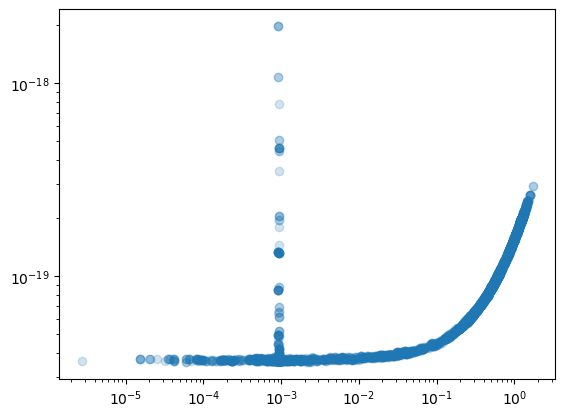

In [146]:
plt.scatter(samples[:,1], samples[:,0], alpha=0.2)
plt.xscale('log')
plt.yscale('log')

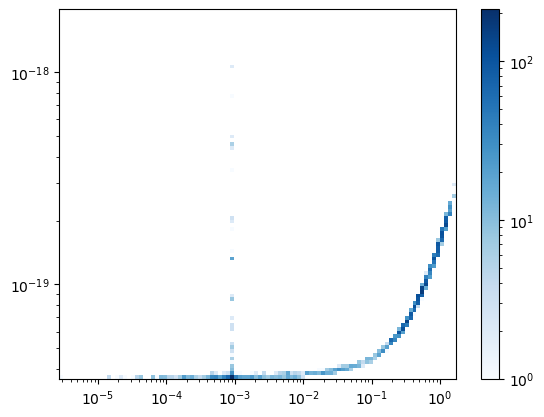

In [143]:
bins=100
xbins = np.logspace(np.log10(np.min(samples[:,1])),np.log10(np.max(samples[:,1])),bins+1)
ybins = np.logspace(np.log10(np.min(samples[:,0])),np.log10(np.max(samples[:,0])),bins+1)

plt.hist2d(samples[:,1], samples[:,0], bins=[xbins,ybins], cmap='Blues', norm='log')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [139]:
def plot_loghist(x, bins):
    logbins = np.logspace(np.log10(np.min(x)),np.log10(np.max(x)),bins+1)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.yscale('log')

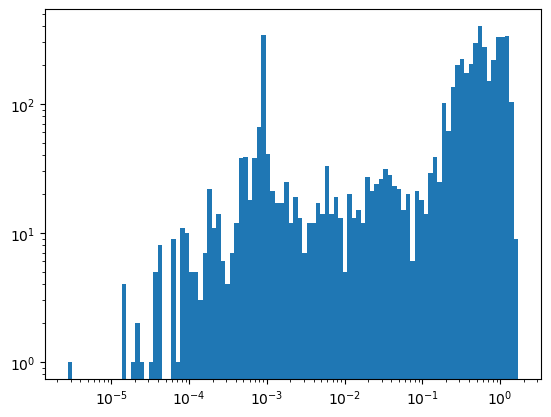

In [140]:
bins=100
plot_loghist(samples[:,1], bins=bins)


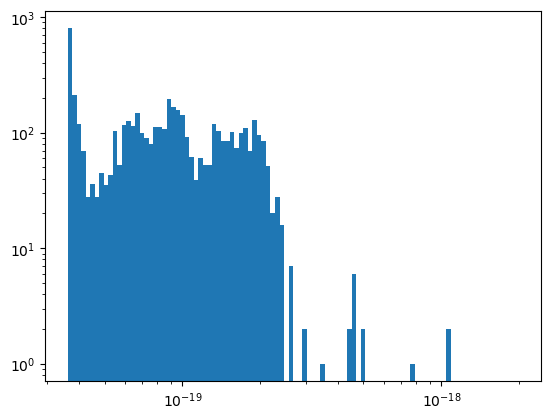

In [141]:
plot_loghist(samples[:,0], bins=bins)

In [125]:
samples[:,1]

array([-0.03247304, -0.03121125, -0.0324903 , ...,  0.68898565,
        0.4675836 ,  1.51329592])

In [149]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(300, 2)


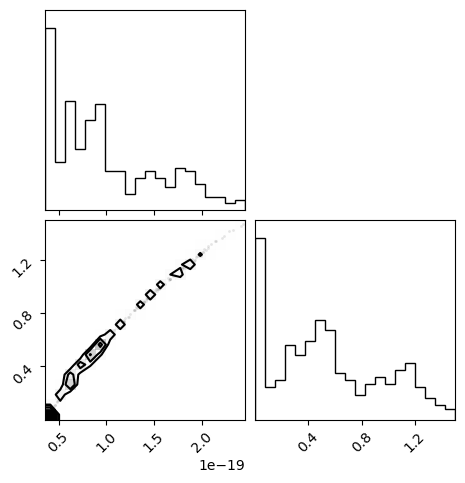

In [150]:
fig = corner.corner(flat_samples) #LOL this is so bad

In [223]:
leading_factors = (norm * 4*np.pi *const.c ** -3).to(u.s**3/u.cm**3)

def func(T_b, p0, cluster):
    sigma0 = p0[0]*u.cm**2
    m_chi=p0[1]*u.GeV
    T_b = T_b*u.GeV
    
    V=cluster.volume.to(u.cm**3)
    x = (3*const.c*c(n)*V*cluster.rho_dm*cluster.rho_b*sigma0/(cluster.m_b+m_chi)**2).to(1/u.s)
    gm2 = ((const.G * cluster.bh_mass()) ** 2).to(u.cm**6/u.s**4)
    frac = ((mu * cluster.m_b) ** (5 / 2) / cluster.adiabatic_idx ** (3 / 2)).to(u.GeV**(5/2))
    nb = (2 * cluster.n_e).to(u.cm ** (-3)) # baryon number density
    D = (cluster.epsilon*leading_factors*gm2*frac*(1/nb**(2/3))**(-3/2)) # removed k_B from original function because we are working in GeV here
    T_chi = virial_temp(cluster, m_chi)
    
    numerator = D*T_b**(-3/2)
    denominator = (T_b - T_chi)*(T_chi/m_chi + T_b/cluster.m_b)**(1/2)
    
    return ((numerator/denominator - x)*const.hbar).to(u.GeV, equivalencies=u.temperature_energy())
    
    

In [224]:
def virial_temp(cluster, m_chi, f_chi = 1, m_psi=0.1*u.GeV):
    frac = (f_chi / m_chi + (1 - f_chi) / m_psi)
    M_kg = cluster.mass.to(u.kg, equivalencies=u.mass_energy())
    return (0.3 * const.G * M_kg / (cluster.radius * frac) * 1 / const.c ** 2).to(u.GeV)

In [229]:
def T_b(p0, cluster): # "exact"
    x0 = 1e-6 * u.GeV # starting estimate (could even do this using T_b_small)
    return fsolve(func, x0, args=(p0, cluster))*u.GeV
    

In [230]:
i = 1
test_cluster = Cluster(
    cls_table['r200'][i], 
    cls_table['M200'][i], 
    cls_table['sig200'][i], 
    m500=cls_table['M500'][i])
T_b([1e-19, 1e-4], test_cluster)


<Quantity [4.1256881e-06] GeV2>

In [231]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[T_data, var])

In [232]:
state2 = sampler2.run_mcmc(p0, n_burnin, progress=True)
sampler2.reset()

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
You must install the tqdm library to use progress indicators with emcee
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method,

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

In [233]:
sampler2.run_mcmc(state2, n_steps, progress=True)

You must install the tqdm library to use progress indicators with emcee
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method,

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elea

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpa

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elea

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elea

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elea

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elea

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elea

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/pyth

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/elea

State([[3.50110254e-20 9.00284684e-02]
 [1.24971026e-08 1.94364842e-01]
 [3.46886218e-20 8.93316529e-02]
 [1.27843359e-08 1.96705695e-01]
 [3.57813776e-20 9.01817520e-02]], log_prob=[ -4015.58072019 -26998.6082769   -4017.14143857 -26998.6082769
  -4017.5611223 ], blobs=[], random_state=('MT19937', array([4005542613,  247424337, 1177416618, 2588879209, 3355615281,
       1568391109, 2607620012, 3062205303, 1783566313, 1490455395,
       3119576709, 2990345672,  142390781, 4142128055, 2150213843,
        110975567, 3024164610,  618393847, 3250991679,  466011801,
       3515918275,  191009041, 2161914451, 1248455011, 3553444500,
       2275816284, 1758524778, 4278439725, 3178843399, 2459364966,
       1689391119, 1372500476, 2392676846, 1581623922, 2484721429,
        489359476, 3984764027,  364838859, 2208767175, 2243834479,
       3176602923,  636145465, 1659821788,   10930829,  978127610,
        354066793, 3139185231,  140123071, 4141609704, 1063224800,
       2876913507, 3376397018,

In [234]:
samples2 = sampler2.get_chain(flat=True)

In [235]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler2.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.220


In [236]:
np.median(samples2[:,0]), np.median(samples2[:,1]) # want to have higher value of mchi

(3.539944794644672e-20, 0.09009144406914346)

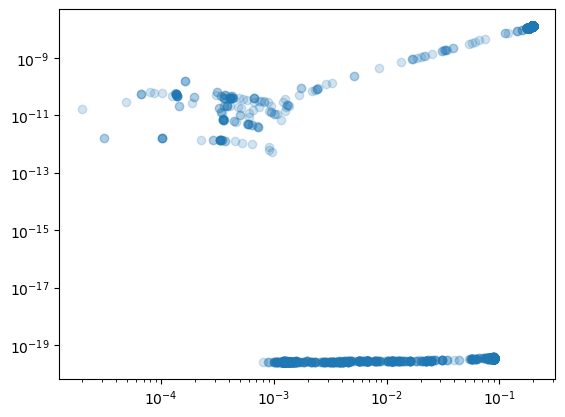

In [237]:
plt.scatter(samples2[:,1], samples2[:,0], alpha=0.2)
plt.xscale('log')
plt.yscale('log')

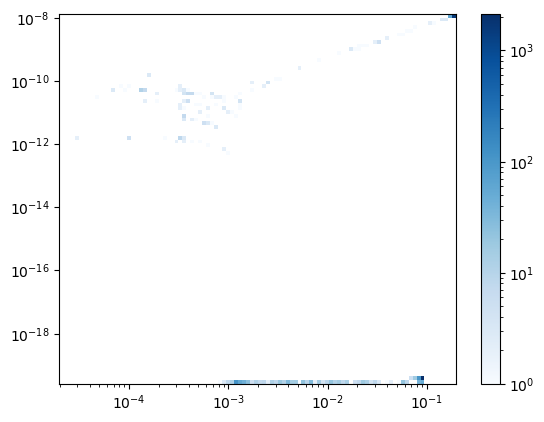

In [238]:
bins=100
xbins = np.logspace(np.log10(np.min(samples2[:,1])),np.log10(np.max(samples2[:,1])),bins+1)
ybins = np.logspace(np.log10(np.min(samples2[:,0])),np.log10(np.max(samples2[:,0])),bins+1)

plt.hist2d(samples2[:,1], samples2[:,0], bins=[xbins,ybins], cmap='Blues', norm='log')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

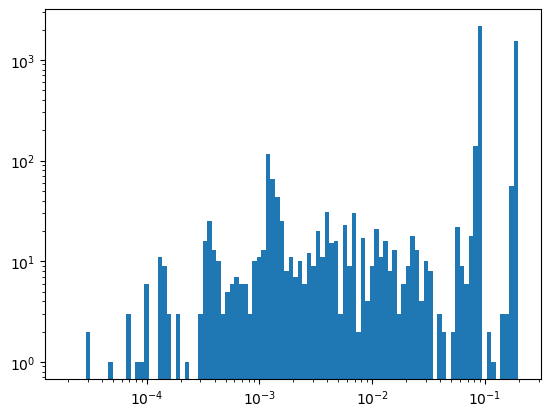

In [239]:
bins=100
plot_loghist(samples2[:,1], bins=bins)

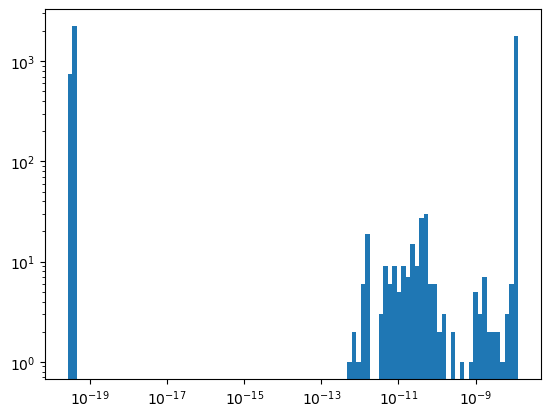

In [240]:
plot_loghist(samples2[:,0], bins=bins)

In [241]:
flat_samples2 = sampler2.get_chain(discard=100, thin=15, flat=True)
print(flat_samples2.shape)

(300, 2)


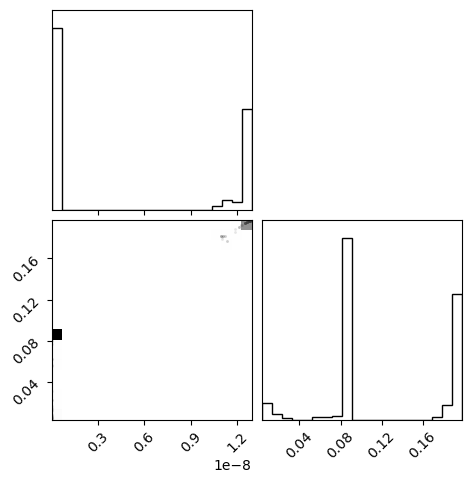

In [242]:
fig2 = corner.corner(flat_samples2) #LOL this is so bad